In [1]:
import os

if not "src" in os.listdir():
    os.chdir("../../")
os.listdir()

['src',
 'requirements.txt',
 'tests',
 '.pytest_cache',
 '.idea',
 '.githooks',
 '.git',
 'lightning_logs',
 'notebooks',
 '.pre-commit-config.yaml',
 'old_code',
 'data',
 'README.md',
 '.gitignore',
 'pytest.ini']

In [2]:
import torch
from src.utils.data.pcm.mnist_cond_trans_dataset import (
    ConditionalMNIST,
    get_ConditionalMnistDataloader,
)
from src.utils.config import load_config_from_path
from pathlib import Path
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from argparse import Namespace

In [3]:
import matplotlib.pyplot as plt


def plot_original_vs_reconstructed(org_imgs, reconstructed_imgs, num_images=8):
    """
    Plots a grid of original and reconstructed images.

    Parameters:
    org_imgs (torch.Tensor): The original images.
    reconstructed_imgs (torch.Tensor): The reconstructed images.
    num_images (int): The number of images to display. Default is 8.
    """
    # Create a figure with a grid of subplots
    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))

    # Plot original and reconstructed images
    for i in range(num_images):
        # Original images
        original = org_imgs[i][0]
        axes[0, i].imshow(original, cmap="gray")
        axes[0, i].axis("off")

        # Reconstructed images
        reconstruction = reconstructed_imgs[i][0].detach()
        axes[1, i].imshow(reconstruction, cmap="gray")
        axes[1, i].axis("off")

    # Set titles
    axes[0, 0].set_title("Original Images")
    axes[1, 0].set_title("Reconstructed Images")

    plt.tight_layout()
    plt.show()

In [ ]:
# import torch.nn as nn
# import torch.nn.functional as F
# import pytorch_lightning as pl
# from src.utils.common_types import Batch
# from einops import rearrange


# class AE(pl.LightningModule):
#     def __init__(self):
#         super(AE, self).__init__()
#         self.encoder = nn.Sequential(nn.Linear(784, 512), nn.ReLU(), nn.Linear(512, 2))
#         self.decoder = nn.Sequential(
#             nn.Linear(2, 512), nn.ReLU(), nn.Linear(512, 784), nn.Sigmoid()
#         )

#     def training_step(self, batch: Batch):
#         input = batch["img"]
#         x = rearrange(input, "b 1 h w -> b (1 h w)")
#         x = self.encoder(x)
#         x = self.decoder(x)
#         x = rearrange(x, "b (1 h w) -> b 1 h w", h=28)
#         mse = F.mse_loss(x, input, reduction="sum")
#         self.log(
#             name="mse", value=mse.item(), prog_bar=True, on_epoch=True, on_step=True
#         )
#         return mse

#     def configure_optimizers(self):
#         return torch.optim.Adam(
#             params=list(self.encoder.parameters()) + list(self.decoder.parameters()),
#             lr=0.001,
#         )
# ae = AE()
# # trainer = pl.Trainer(max_epochs=100)

# # trainer.fit(
# #     model=ae,
# #     train_dataloaders=cmnist_train_dataloader,
# #     # val_dataloaders=cmnist_val_dataloader,
# # )

In [4]:
train_data_cfg = load_config_from_path(
    file_path=Path("notebooks") / "experiments" / "config" / "pcm-mnist-00-train.yaml"
)
cmnist_train = ConditionalMNIST(cfg=train_data_cfg)
cmnist_train_dataloader = get_ConditionalMnistDataloader(
    cmnist=cmnist_train, batch_size=128, shuffle=True
)

train_data_cfg.train = False
cmnist_val = ConditionalMNIST(cfg=train_data_cfg)
cmnist_val_dataloader = get_ConditionalMnistDataloader(
    cmnist=cmnist_train, batch_size=128, shuffle=True
)

In [5]:
def show_img(img: torch.Tensor, figsize=(2, 2)):
    img = transforms.ToPILImage()(img)
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.show()

In [6]:
cmnist_train[0].keys()

dict_keys(['img', 'condition_token_ids', 'condition_values'])

In [7]:
cmnist_train[0]["condition_token_ids"].dtype, cmnist_train[0][
    "condition_token_ids"
].shape

(torch.int64, torch.Size([1]))

Condition tokens (0 - pad): tensor([1]) 
Condition values: tensor([5.])


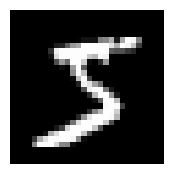

Condition tokens (0 - pad): tensor([1]) 
Condition values: tensor([0.])


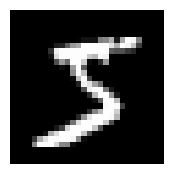

Condition tokens (0 - pad): tensor([0]) 
Condition values: tensor([5.])


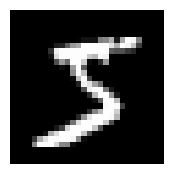

Condition tokens (0 - pad): tensor([1]) 
Condition values: tensor([5.])


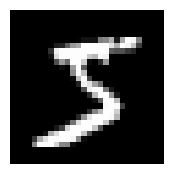

Condition tokens (0 - pad): tensor([0]) 
Condition values: tensor([0.])


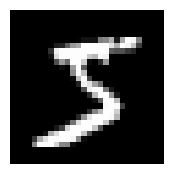

In [8]:
for _ in range(5):
    print(
        f'Condition tokens (0 - pad): {cmnist_train[0]["condition_token_ids"]} \nCondition values: {cmnist_train[0]["condition_values"]}'
    )
    show_img(img=cmnist_train[0]["img"][0])

### Model

In [43]:
from src.models.components.chain import ChainAE

chain_cfg = load_config_from_path(
    file_path=Path("notebooks") / "experiments" / "config" / "pcm-01.yaml"
)
chainae = ChainAE(cfg=chain_cfg)
chainae

ChainAE(
  (_chain): ModuleDict(
    (br-0): BatchRearranger()
    (bs-0): BlockStack(
      (blocks): Sequential(
        (0): Block(
          (layer): ModuleList(
            (0): Linear(in_features=784, out_features=512, bias=True)
            (1): ReLU()
          )
        )
        (1): Linear(in_features=512, out_features=2, bias=True)
      )
    )
    (cf): FuzzyClustering()
    (bs-2): BlockStack(
      (blocks): Sequential(
        (0): Block(
          (layer): ModuleList(
            (0): Linear(in_features=2, out_features=512, bias=True)
            (1): ReLU()
          )
        )
        (1): Linear(in_features=512, out_features=784, bias=True)
      )
    )
    (oa): StandaloneTinyModule(
      (_tiny_module): Sigmoid()
    )
    (br-3): BatchRearranger()
  )
  (_reconstr_loss_fn): MSELoss()
)

In [44]:
trainer = pl.Trainer(max_epochs=100)

trainer.fit(
    model=chainae,
    train_dataloaders=cmnist_train_dataloader,
    # val_dataloaders=cmnist_val_dataloader,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/prz/bioml/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name              | Type       | Params | Mode 
---------------------------------------------------------
0 | _chain            | ModuleDict | 806 K  | train
1 | _reconstr_loss_fn | MSELoss    | 0      | train
---------------------------------------------------------
806 K     Trainable params
0         Non-trainable params
806 K     Total params
3.227     Total estimated model params size (MB)
/home/prz/bioml/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improv

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 17:  89%|████████▊ | 416/469 [00:25<00:03, 16.13it/s, v_num=0, reconstr_step=4.11e+3, reconstr_epoch=4e+3]   

/home/prz/bioml/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [33]:
loaded_chainae = ChainAE.load_from_checkpoint(
    checkpoint_path=Path("lightning_logs")
    / "version_9"
    / "checkpoints"
    / "epoch=99-step=46900.ckpt",
    cfg=chain_cfg,
)

/home/prz/bioml/.venv/lib/python3.10/site-packages/lightning_fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [34]:
dataloader_iter = iter(cmnist_val_dataloader)

torch.Size([128, 1, 28, 28]) torch.Size([128, 1, 28, 28])


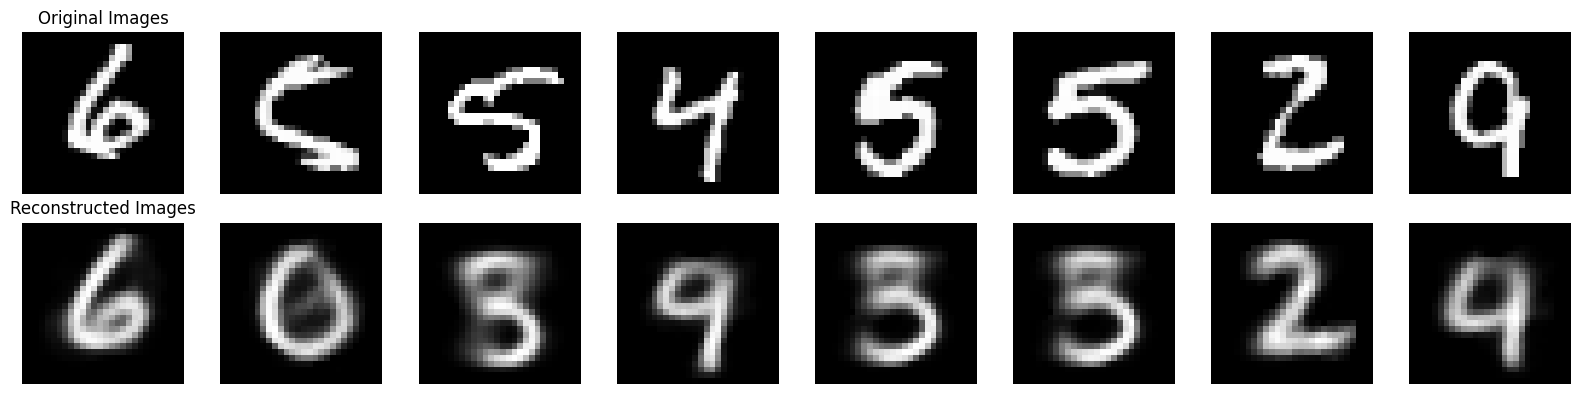

In [40]:
batch = next(dataloader_iter)
org_imgs = batch["img"].clone()
batch["condition_token_ids"].shape
reconstructed_imgs = loaded_chainae(batch)["img"]

print(org_imgs.shape, reconstructed_imgs.shape)

plot_original_vs_reconstructed(org_imgs, reconstructed_imgs, num_images=8)

# TODO
- add flexible commands with gettatr to run methods - remove kwargs altering behaviour
- add sampling from prior
- perhaps add chain_link_name for readibility of the commands

In [11]:
batch = next(iter(cmnist_val_dataloader))
org_imgs = batch["img"].clone()
batch["condition_token_ids"].shape

torch.Size([128, 1])

In [12]:
output_batch = chainae(batch)

In [13]:
# output = chainae.run_processing_command(
#     batch=batch,
#     command_name="sample_conditionally_from_prior",
#     dynamic_kwargs={
#         "pvclgmn": Namespace(n_latent_samples=8),
#         "command-br-1-dynamic": Namespace(s=8),
#     },
# )
# for i in range(5):
#     print(
#         f'Condition tokens (0 - pad): {output_batch["condition_token_ids"][0][0]} \nCondition values: {output_batch["condition_values"][0][0]}'
#     )
#     show_img(img=output_batch["img"][0][0])

In [14]:
output_batch["img"].shape

torch.Size([128, 1, 28, 28])